In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38437")
client

<Client: 'tcp://127.0.0.1:38437' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'

In [43]:

# Time set-up
years = np.arange(2002,2013,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = [6940080, 7097760, 7255440, 7413120, 
            7570800, 7728480, 7886160, 8043840,
            8201520, 8359200, 8516880] # first steps 
fin_time = [7095600, 7253280, 7410960, 7568640,
            7726320, 7884000, 8041680, 8199360,
            8357040, 8514720, 8672400] # last steps 
ntimes = np.zeros([len(years), nfile],'int')
for index in range(len(years)):
    ntimes[index,:] = np.arange(ini_time[index],fin_time[index]+dnf,dnf)

# Ensemble members 
membs = np.arange(36,60,dtype=int)
ddir = '/tank/spectre/tuchida/chaocean/RUNS/orar/'

In [5]:

gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'

In [6]:
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures

# Compute and save Ertel PV and flux

In [44]:
# Compute and save Ertel PV
year = years[0]

for itime in ntimes[0]:
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (36,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)


    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)

    delta = .5*(dsz.delta_outer[1:].data 
                + dsz.delta_outer[:-1].data)
    dsz.coords['delta'] = ('delta',delta)

    grid = Grid(dsz, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
           )


    uhat = dsb.uhat
    vhat = dsb.vhat
    varpihat = dsb.varpihat

    #fC = xr.apply_ufunc(gsw.f, ds.YC, dask='parallelized', output_dtypes=['float',])
    fG = xr.apply_ufunc(gsw.f, ds.YG, dask='parallelized', output_dtypes=['float',])
    
    buoyb = -grav * dsz.delta * rho0**-1
    buoybp1 = -grav * dsz.delta_outer * rho0**-1

    sigmab = (dsz.dzetab * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    sigmaxb = (dsz.dzetaxb * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    sigmayb = (dsz.dzetayb * -grid.diff(buoyb,'Z',boundary='extend')**-1)

    vort = (grid.diff(vhat*ds.dyC,'X') 
            - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
           ) * ds.rAz**-1
    
    Pi = (vort + fG) * grid.interp(sigmaxb, 'Y')**-1
    
    Ro = (grid.diff(vhat*ds.dyC,'X') 
                    - grid.diff(uhat*ds.dxC,'Y',boundary='extend')
         ) * ds.rAz**-1 * fG**-1
          
    Ju = grid.interp(Pi, 'Y') * uhat
    Jv = grid.interp(Pi, 'X') * vhat 
    
#     Pi_f = (1. + grid.interp(grid.interp(vort,'X'),
#                              'Y',boundary='fill') * fC**-1
#            ) * sigmab**-1
    
    
    ds.close()
    dsb.close()
    dsz.close()
    
    
    dsave = Pi.to_dataset(name='Pi').chunk({'YG':ychunk})   
    dsave['Ro'] = Ro.chunk({'YG':ychunk})  
    dsave.to_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                                            % (year,itime)), mode='w')
    dsave.close()
    
    dsave1 = Ju.to_dataset(name='Ju').chunk({'YC':ychunk,'XG':xchunk})   
    dsave1['Jv'] = Jv.chunk({'YG':ychunk,'XC':xchunk})
    dsave1.to_zarr(op.join(savedir,twadir,'run%4d/mean_PV_flux/%010d/' 
                                            % (year,itime)), mode='w')
    dsave1.close()
    
    
    print(itime)

6940080
6942240
6944400
6946560
6948720
6950880
6953040
6955200
6957360
6959520
6961680
6963840
6966000
6968160
6970320
6972480
6974640
6976800
6978960
6981120
6983280
6985440
6987600
6989760
6991920
6994080
6996240
6998400
7000560
7002720
7004880
7007040
7009200
7011360
7013520
7015680
7017840
7020000
7022160
7024320
7026480
7028640
7030800
7032960
7035120
7037280
7039440
7041600
7043760
7045920
7048080
7050240
7052400
7054560
7056720
7058880
7061040
7063200
7065360
7067520
7069680
7071840
7074000
7076160
7078320
7080480
7082640
7084800
7086960
7089120
7091280
7093440
7095600


# Animation of PV

In [44]:
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 783, XG: 1000, YG: 783, Z: 46, Zp1: 47,
              Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3645 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 392, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 391, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(392, 250), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(392, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(391, 250), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 391, 250), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

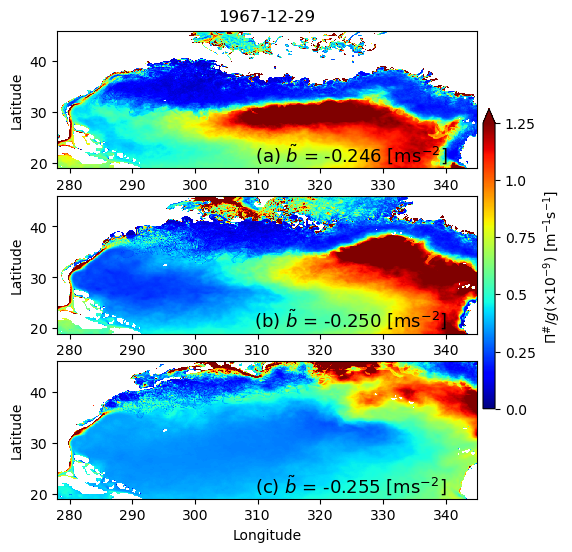

In [106]:
# PV is animated in three layers
writer = animation.FFMpegWriter(fps=7, metadata=dict(artist='Me'), bitrate=-1)
fig, ax = plt.subplots(figsize=(6,6), nrows=3, ncols=1)
plt.subplots_adjust(bottom=0.1, left=0.1, right = 0.8)

XG_sub = [278, 345]
YG_sub = [19, 46]

delta_isub = [18,21,26] # [18, 28]

ims=[]
count = 0 
year = years[0]
for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
    buoyancy = - grav * Pi.delta_outer.isel(delta_outer = delta_isub) * rho0**-1
    
    ttl = ax[0].text(0.5, 1.1, str(dates.date[count]),
               horizontalalignment = 'center',  fontsize = 12,
               verticalalignment = 'center', transform = ax[0].transAxes)
    
    im0 = ax[0].pcolormesh(Pi.isel(delta_outer = delta_isub[0]).XG, 
                        Pi.isel(delta_outer = delta_isub[0]).YG, 
                        Pi.isel(delta_outer = delta_isub[0]), 
                        vmin=0, vmax=1.25e-9, cmap='jet', 
                        rasterized=True
                       )   
   
    label0 = ax[0].text(0.7, 0.1, r'(a) $\tilde{b}$ = %1.3f [ms$^{-2}$]'%buoyancy[0], 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[0].transAxes)
    ax[0].set_ylabel('Latitude')
    # ax[0].set_xlabel('Longitude')
    
    im1 = ax[1].pcolormesh(Pi.isel(delta_outer = delta_isub[1]).XG, 
                        Pi.isel(delta_outer = delta_isub[1]).YG, 
                        Pi.isel(delta_outer = delta_isub[1]), 
                        vmin=0, vmax=1.25e-9, cmap='jet', 
                        rasterized=True
                       )  
    
    label1 = ax[1].text(0.7, 0.1, r'(b) $\tilde{b}$ = %1.3f [ms$^{-2}$]'%buoyancy[1], 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[1].transAxes)
    ax[1].set_ylabel('Latitude')
    # ax[1].set_xlabel('Longitude')
    
    im2 = ax[2].pcolormesh(Pi.isel(delta_outer = delta_isub[2]).XG, 
                        Pi.isel(delta_outer = delta_isub[2]).YG, 
                        Pi.isel(delta_outer = delta_isub[2]), 
                        vmin=0, vmax=1.25e-9, cmap='jet', 
                        rasterized=True
                       )
    
    label2 = ax[2].text(0.7, 0.1, r'(c) $\tilde{b}$ = %1.3f [ms$^{-2}$]'%buoyancy[2], 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[2].transAxes)
    ax[2].set_ylabel('Latitude')
    ax[2].set_xlabel('Longitude')
    
    
    
    # colour bars
    if count == 0:
        caxes = fig.add_axes((0.81, 0.25, 0.02, 0.5))
        cbar = fig.colorbar(im0, cax = caxes, 
                        ticks = [0, 0.25e-9, 0.5e-9, 0.75e-9, 1e-9, 1.25e-9],
                        orientation='vertical', shrink=.7, extend = 'max')
        caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
        cbar.set_label(r'$\Pi^{\#}/g (\times 10^{-9})$ [m$^{-1}$s$^{-1}$]', fontsize=10)
        
    
    ims.append([ttl,im0,im1,im2,#cim0,cim1,cim2,
               label0,label1,label2])  
    count += 1
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat = True, repeat_delay=50)
ani.save(figdir+'PV.mp4', writer=writer)

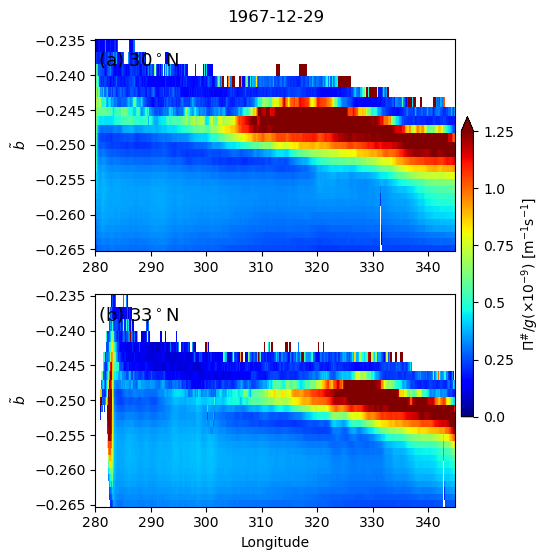

In [42]:
# PV is animated in three layers
writer = animation.FFMpegWriter(fps=7, metadata=dict(artist='Me'), bitrate=-1)
fig, ax = plt.subplots(figsize=(6,6), nrows=2, ncols=1)
plt.subplots_adjust(bottom=0.1, left=0.2, right = 0.8)

XG_sub = [280, 345]
YG_sub = [19, 46]

delta_sub = [24, 27] # Values not indices

ims=[]
count = 0 
year = years[0]
for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1]),
                     delta_outer = slice(delta_sub[0], delta_sub[1])
                    )* grav**-1
    buoyancy = - grav * Pi.delta_outer * rho0**-1
    
    ttl = ax[0].text(0.5, 1.1, str(dates.date[count]),
               horizontalalignment = 'center',  fontsize = 12,
               verticalalignment = 'center', transform = ax[0].transAxes)
    
    im0 = ax[0].pcolormesh(Pi.XG, 
                           buoyancy, 
                           Pi.sel(YG = 30, method = 'nearest'
                                 ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                      delta_outer = slice(delta_sub[0], 
                                                          delta_sub[1])
                                      ).transpose(), 
                           vmin=0, vmax=1.25e-9, cmap='jet', 
                           rasterized=True
                           )   
   
    label0 = ax[0].text(0.12, 0.9, r'(a) $30^\circ$N', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[0].transAxes)
    ax[0].set_ylabel(r'$\tilde{b}$')
    # ax[0].set_xlabel('Longitude')
    
    im1 = ax[1].pcolormesh(Pi.XG, 
                           buoyancy, 
                           Pi.sel(YG = 33, method = 'nearest').transpose(), 
                           vmin=0, vmax=1.25e-9, cmap='jet', 
                           rasterized=True
                           )   
    
    label1 = ax[1].text(0.12, 0.9, r'(b) $33^\circ$N', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[1].transAxes)
    ax[1].set_ylabel(r'$\tilde{b}$')
    ax[1].set_xlabel('Longitude')
    
    
    # colour bars
    if count == 0:
        caxes = fig.add_axes((0.81, 0.25, 0.02, 0.5))
        cbar = fig.colorbar(im0, cax = caxes, 
                        ticks = [0, 0.25e-9, 0.5e-9, 0.75e-9, 1e-9, 1.25e-9],
                        orientation='vertical', shrink=.7, extend = 'max')
        caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
        cbar.set_label(r'$\Pi^{\#}/g (\times 10^{-9})$ [m$^{-1}$s$^{-1}$]', fontsize=10)
        
    
    ims.append([ttl,im0,im1,#cim0,cim1,cim2,
               label0,label1])  
    count += 1
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat = True, repeat_delay=50)
ani.save(figdir+'PV_WE.mp4', writer=writer)

# Diagnose PV fields

annual mean PV field and contour 

In [11]:
year = years[0]
XG_sub = [287, 292]#[280, 345]
YG_sub = [28, 35]#[23, 42]

for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    if itime == ntimes[0,0]:
        Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                         YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
        buoyancy = - grav * Pi.delta_outer * rho0**-1
    else:
        Pi = xr.concat([Pi,
                        dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                                    YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
                       ],'ntime')

Pi.coords['ntime'] = ('ntime',range(73))   

# time-mean of each months
Pi_mean = Pi.where(Pi>0).mean('ntime',skipna=True) 

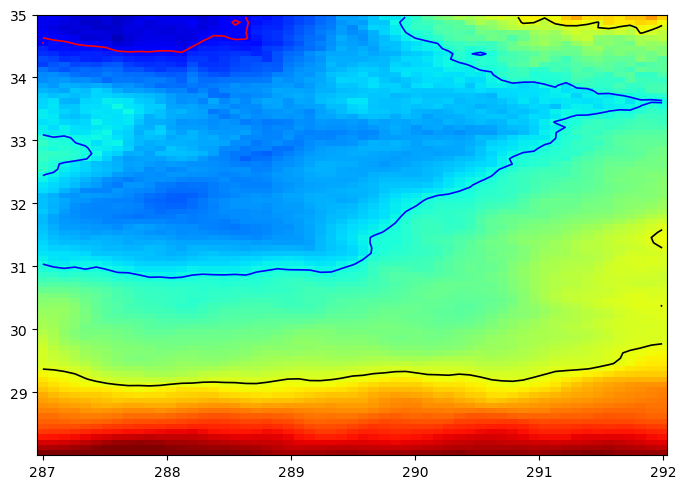

In [35]:
delta_isub = [21]
labels = [['a','b','c'],
          ['d','e','f'],
          ['g','h','i']]

fig, ax = plt.subplots(figsize=(9,5))
fig.tight_layout()
plt.subplots_adjust(left=0.1, right = 0.8)

dd = 0
for d_index in delta_isub:
    im0 = ax.pcolormesh(Pi_mean.isel(delta_outer = d_index).XG, 
                            Pi_mean.isel(delta_outer = d_index).YG, 
                            Pi_mean.isel(delta_outer = d_index), 
                            vmin=1.4e-10, vmax=2.2e-10, cmap='jet', 
                            rasterized=True
                           )   
    ax.contour(Pi_mean.isel(delta_outer = d_index).XG, 
                     Pi_mean.isel(delta_outer = d_index).YG, 
                     Pi_mean.isel(delta_outer = d_index),
                     levels = [1.5e-10,1.7e-10,1.9e-10],
                     linewidths=1.2, colors=['r','b','k'])
    # ax.text(0.05, 0.9, labels[dd], 
    #            horizontalalignment = 'center', fontsize=13,
    #            verticalalignment = 'center', transform = ax[dd,0].transAxes)
    # if dd == 0:
    #     ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.246')
    # elif dd == 1:
    #     ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.25')
    # elif dd == 2:
    #     ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.254')

   

The seasons are separated as follows: last winter 0 - 11, spring 12 - 29, summer 30 - 48, autumn 49 - 66, winter 67 - 72

In [52]:
# Get mean PV fields for 4 seasons, normalise them by 1/g to get unit 1/ms
year = years[0]
XG_sub = [280, 345]
YG_sub = [23, 42]

for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    if itime == ntimes[0,0]:
        Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                         YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
        buoyancy = - grav * Pi.delta_outer * rho0**-1
    else:
        Pi = xr.concat([Pi,
                        dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                                    YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
                       ],'ntime')

Pi.coords['ntime'] = ('ntime',range(73))   

# time-mean of each months
Pi_jan = Pi.where(Pi>0).isel(ntime = slice(0,6)).mean('ntime',skipna=True) 
Pi_feb = Pi.where(Pi>0).isel(ntime = slice(6,12)).mean('ntime',skipna=True)
Pi_mar = Pi.where(Pi>0).isel(ntime = slice(12,18)).mean('ntime',skipna=True)
Pi_apr = Pi.where(Pi>0).isel(ntime = slice(18,24)).mean('ntime',skipna=True)
Pi_may = Pi.where(Pi>0).isel(ntime = slice(24,30)).mean('ntime',skipna=True)
Pi_jun = Pi.where(Pi>0).isel(ntime = slice(30,36)).mean('ntime',skipna=True) 
Pi_jul = Pi.where(Pi>0).isel(ntime = slice(36,42)).mean('ntime',skipna=True)
Pi_aug = Pi.where(Pi>0).isel(ntime = slice(42,49)).mean('ntime',skipna=True)
Pi_sep = Pi.where(Pi>0).isel(ntime = slice(49,55)).mean('ntime',skipna=True)
Pi_oct = Pi.where(Pi>0).isel(ntime = slice(55,61)).mean('ntime',skipna=True)
Pi_nov = Pi.where(Pi>0).isel(ntime = slice(61,67)).mean('ntime',skipna=True)
Pi_dec = Pi.where(Pi>0).isel(ntime = slice(67,73)).mean('ntime',skipna=True)


A slice along latitude 30N has been used to diagnose the isopycnal layers where low PV pool is located. Black contour centered around b = -0.25 is the contour of the low PV pool and red contour is for the minimum PV which is renewed annual.

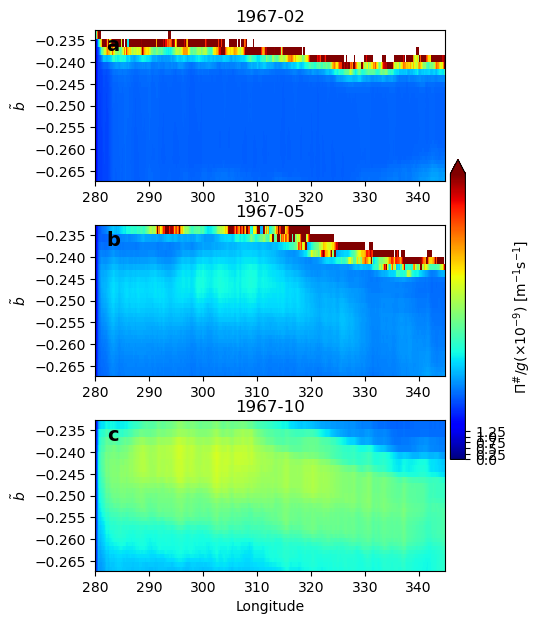

In [54]:
fig, ax = plt.subplots(figsize=(5,6), nrows=3, ncols=1)
fig.tight_layout()
plt.subplots_adjust(left=0.1, right = 0.8)

delta_sub = [23.8, 27.2] # Values not indices

# fields
im0 = ax[0].pcolormesh(Pi_jan.XG, 
                       buoyancy.sel(delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])), 
                       Pi_jan.sel(YG = 30, method = 'nearest'
                             ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                  delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])
                                  ).transpose(), 
                       vmin=0, vmax=1.25e-8, cmap='jet', 
                       rasterized=True
                       )   
im1 = ax[1].pcolormesh(Pi_may.XG, 
                       buoyancy.sel(delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])), 
                       Pi_may.sel(YG = 30, method = 'nearest'
                             ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                  delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])
                                  ).transpose(), 
                       vmin=0, vmax=1.25e-8, cmap='jet', 
                       rasterized=True
                       )   
im2 = ax[2].pcolormesh(Pi_oct.XG, 
                       buoyancy.sel(delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])), 
                       Pi_oct.sel(YG = 30, method = 'nearest'
                             ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                  delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])
                                  ).transpose(), 
                       vmin=0, vmax=1.25e-8, cmap='jet', 
                       rasterized=True
                       )   

# contours
ax[0].contour(Pi_feb.XG, 
                buoyancy.sel(delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])), 
                Pi_feb.sel(YG = 30, method = 'nearest'
                             ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                  delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])
                                  ).transpose(),
                levels = [0.15e-9,0.25e-9,0.3e-9,0.4e-9],
                linewidths=1.2, colors=['r','k','b','g'])
ax[1].contour(Pi_may.XG, 
                buoyancy.sel(delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])), 
                Pi_may.sel(YG = 30, method = 'nearest'
                             ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                  delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])
                                  ).transpose(),
                levels = [0.15e-9,0.25e-9,0.3e-9,0.4e-9],
                linewidths=1.2, colors=['r','k','b','g'])
ax[2].contour(Pi_oct.XG, 
                buoyancy.sel(delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])), 
                Pi_oct.sel(YG = 30, method = 'nearest'
                             ).sel(XG = slice(XG_sub[0],XG_sub[1]),
                                  delta_outer = slice(delta_sub[0], 
                                                      delta_sub[1])
                                  ).transpose(),
                levels = [0.15e-9,0.25e-9,0.3e-9,0.4e-9],
                linewidths=1.2, colors=['r','k','b','g'])
# labels
label0 = ax[0].text(0.05, 0.9, r'a', 
           horizontalalignment = 'center', fontsize=14, weight = 'bold',
           verticalalignment = 'center', transform = ax[0].transAxes)
ax[0].set_ylabel(r'$\tilde{b}$')
ax[0].set_yticks([-0.265,-0.26,-0.255,-0.25,-0.245,-0.24,-0.235])
ax[0].set_title('1967-02')

label1 = ax[1].text(0.05, 0.9, r'b', 
           horizontalalignment = 'center', fontsize=14, weight = 'bold',
           verticalalignment = 'center', transform = ax[1].transAxes)
ax[1].set_ylabel(r'$\tilde{b}$')
ax[1].set_yticks([-0.265,-0.26,-0.255,-0.25,-0.245,-0.24,-0.235])
ax[1].set_title('1967-05')

label2 = ax[2].text(0.05, 0.9, r'c', 
           horizontalalignment = 'center', fontsize=14, weight = 'bold',
           verticalalignment = 'center', transform = ax[2].transAxes)
ax[2].set_ylabel(r'$\tilde{b}$')
ax[2].set_xlabel('Longitude')
ax[2].set_yticks([-0.265,-0.26,-0.255,-0.25,-0.245,-0.24,-0.235])
ax[2].set_title('1967-10')

# bar
caxes = fig.add_axes((0.81, 0.25, 0.03, 0.5))
cbar = fig.colorbar(im0, cax = caxes, 
                ticks = [0, 0.25e-9, 0.5e-9, 0.75e-9, 1e-9, 1.25e-9],
                orientation='vertical', shrink=.7, extend = 'max')
caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
cbar.set_label(r'$\Pi^{\#}/g (\times 10^{-9})$ [m$^{-1}$s$^{-1}$]', fontsize=10)

# plt.savefig(figdir+'PV_longitude.eps', format = 'eps', dpi= 600, 
#             bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 

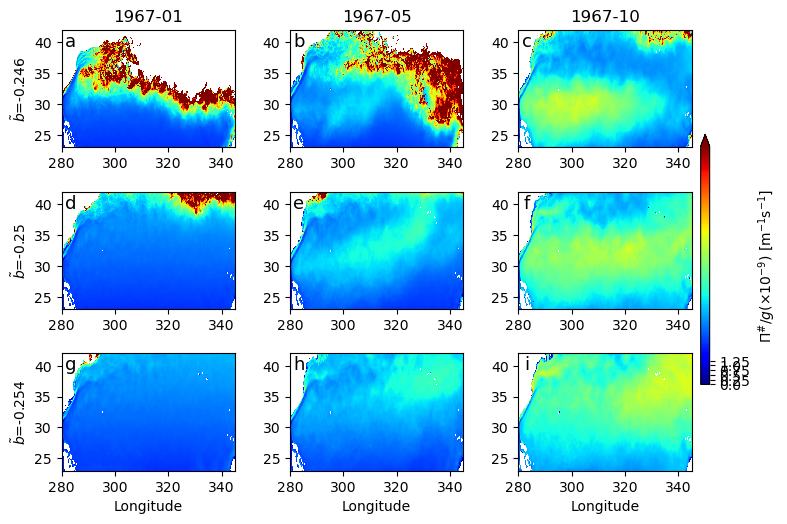

In [58]:
delta_isub = [14, 21, 30]
labels = [['a','b','c'],
          ['d','e','f'],
          ['g','h','i']]

fig, ax = plt.subplots(figsize=(9,5), nrows=3, ncols=3)
fig.tight_layout()
plt.subplots_adjust(left=0.1, right = 0.8)

dd = 0
for d_index in delta_isub:
    im0 = ax[dd,0].pcolormesh(Pi_jan.isel(delta_outer = d_index).XG, 
                            Pi_jan.isel(delta_outer = d_index).YG, 
                            Pi_jan.isel(delta_outer = d_index), 
                            vmin=0, vmax=1.25e-8, cmap='jet', 
                            rasterized=True
                           )   
    ax[dd,0].contour(Pi_jan.isel(delta_outer = d_index).XG, 
                     Pi_jan.isel(delta_outer = d_index).YG, 
                     Pi_jan.isel(delta_outer = d_index),
                     levels = [0.15e-9,0.25e-9],
                     linewidths=1.2, colors=['r','k'])
    ax[dd,0].text(0.05, 0.9, labels[dd][0], 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[dd,0].transAxes)
    if dd == 0:
        ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.246')
    elif dd == 1:
        ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.25')
    elif dd == 2:
        ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.254')

    im1 = ax[dd,1].pcolormesh(Pi_may.isel(delta_outer = d_index).XG, 
                        Pi_may.isel(delta_outer = d_index).YG, 
                        Pi_may.isel(delta_outer = d_index), 
                        vmin=0, vmax=1.25e-8, cmap='jet', 
                        rasterized=True
                       )  
    ax[dd,1].contour(Pi_may.isel(delta_outer = d_index).XG, 
                     Pi_may.isel(delta_outer = d_index).YG, 
                     Pi_may.isel(delta_outer = d_index),
                     levels = [0.15e-9,0.25e-9],
                     linewidths=1.2, colors=['r','k'])
    ax[dd,1].text(0.05, 0.9, labels[dd][1], 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[dd,1].transAxes)
   
    
    
    im2 = ax[dd,2].pcolormesh(Pi_oct.isel(delta_outer = d_index).XG, 
                        Pi_oct.isel(delta_outer = d_index).YG, 
                        Pi_oct.isel(delta_outer = d_index), 
                        vmin=0, vmax=1.25e-8, cmap='jet', 
                        rasterized=True
                       )
    ax[dd,2].contour(Pi_oct.isel(delta_outer = d_index).XG, 
                     Pi_oct.isel(delta_outer = d_index).YG, 
                     Pi_oct.isel(delta_outer = d_index),
                     levels = [0.15e-9,0.25e-9],
                     linewidths=1.2, colors=['r','k'])
    ax[dd,2].text(0.05, 0.9, labels[dd][2], 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[dd,2].transAxes)
    
    if dd == 2:
        ax[dd,0].set_xlabel('Longitude')
        ax[dd,1].set_xlabel('Longitude')
        ax[dd,2].set_xlabel('Longitude')
    if dd == 0:
        ax[dd,0].set_title('1967-01')
        ax[dd,1].set_title('1967-05')
        ax[dd,2].set_title('1967-10')

    dd += 1

# colour bars

caxes = fig.add_axes((0.81, 0.25, 0.01, 0.5))
cbar = fig.colorbar(im0, cax = caxes, 
                ticks = [0, 0.25e-9, 0.5e-9, 0.75e-9, 1e-9, 1.25e-9],
                orientation='vertical', shrink=.7, extend = 'max')
caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
cbar.set_label(r'$\Pi^{\#}/g (\times 10^{-9})$ [m$^{-1}$s$^{-1}$]', fontsize=10)
# plt.savefig(figdir+'PV_layers.eps', format = 'eps', dpi= 600, bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 

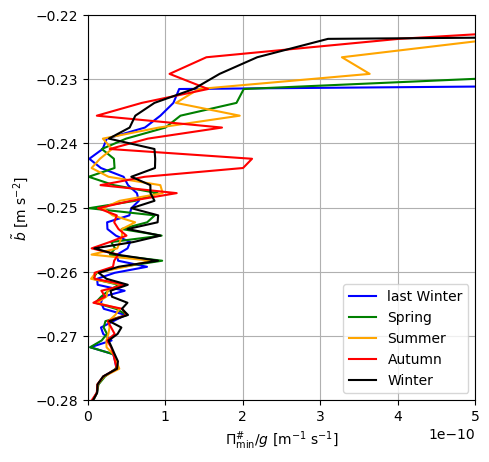

In [11]:
# Determine the depth of minimum PV in the upper ocean: we focus on b in the range (-0.24, -0.255), potential peak of minimum is 
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Pi_winter1.min(['XG','YG']), buoyancy, color = 'blue', label='last Winter')
ax.plot(Pi_spring.min(['XG','YG']), buoyancy, color = 'green', label='Spring')
ax.plot(Pi_summer.min(['XG','YG']), buoyancy, color = 'orange', label='Summer')
ax.plot(Pi_autumn.min(['XG','YG']), buoyancy, color = 'red', label='Autumn')
ax.plot(Pi_winter2.min(['XG','YG']), buoyancy, color = 'black', label='Winter')
ax.legend(loc = 'lower right')
ax.set_xlabel(r'$\Pi_{\min}^{\#}/g$ [m$^{-1}$ s$^{-1}$]')  # Add an x-label to the axes.
ax.set_ylabel(r'$\tilde{b}$ [m s$^{-2}$]')
ax.set_xlim(0, .5e-9)
ax.set_ylim(-0.28, -0.22)
ax.grid(True)
#plt.savefig(figdir+'minPV.eps', format = 'eps', dpi= 600, bbox_inches = 'tight', pad_inches = 0.1)
plt.show() # must add this after savefig

/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


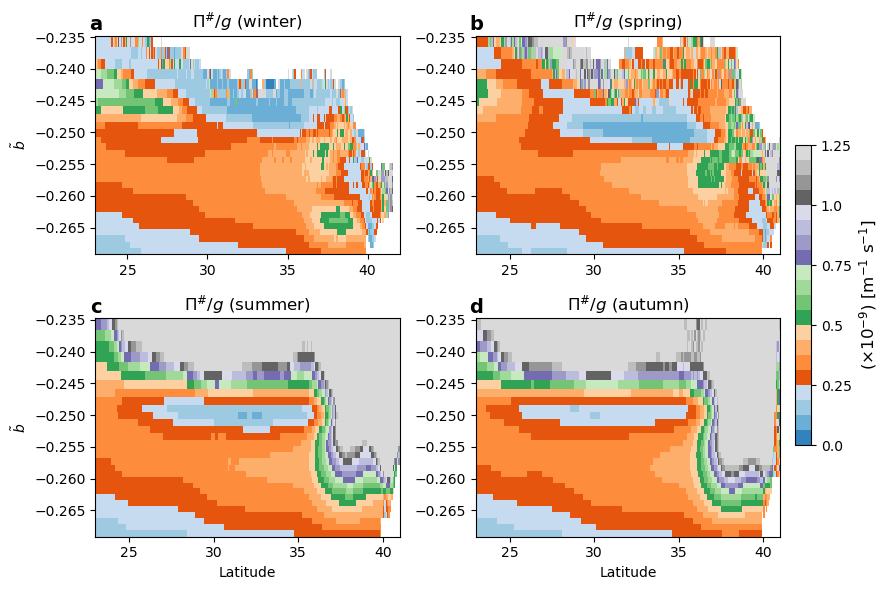

In [142]:
# Now focus on one layer, plot side views (Latitude Y vs buoyancy, XC = 290E)
delta_min = 24
delta_max = 27.4

fig, axes = plt.subplots(figsize=(8,6), nrows=2, ncols=2)
fig.set_tight_layout(True)
im1 = axes[0,0].pcolormesh(Pi_winter1.YG, 
                           buoyancy.sel(delta_outer = slice(delta_min,delta_max)), 
                           Pi_winter1.sel(delta_outer = slice(delta_min,delta_max))
                           .sel(XG = 290, method = 'nearest').transpose(),
                           vmin=0, vmax=1.25e-9,
                           cmap='tab20c', 
                            rasterized=False)
im2 = axes[0,1].pcolormesh(Pi_spring.YG.sel(YG = slice(20,41)), 
                           buoyancy.sel(delta_outer = slice(delta_min,delta_max)), 
                           Pi_spring.sel(delta_outer = slice(delta_min,delta_max))
                           .sel(YG = slice(20,41)).sel(XG = 290, method = 'nearest').transpose(),
                           vmin=0, vmax=1.25e-9,
                           cmap='tab20c', 
                            rasterized=False)
im3 = axes[1,0].pcolormesh(Pi_summer.YG.sel(YG = slice(20,41)), 
                           buoyancy.sel(delta_outer = slice(delta_min,delta_max)), 
                           Pi_summer.sel(delta_outer = slice(delta_min,delta_max))
                           .sel(YG = slice(20,41)).sel(XG = 290, method = 'nearest').transpose(),
                           vmin=0, vmax=1.25e-9,
                           cmap='tab20c', 
                            rasterized=False)
im4 = axes[1,1].pcolormesh(Pi_autumn.YG.sel(YG = slice(20,41)), 
                           buoyancy.sel(delta_outer = slice(delta_min,delta_max)), 
                           Pi_autumn.sel(delta_outer = slice(delta_min,delta_max))
                           .sel(YG = slice(20,41)).sel(XG = 290, method = 'nearest').transpose(),
                           vmin=0, vmax=1.25e-9,
                           cmap='tab20c', 
                            rasterized=False)



axes[0,0].set_title(r'$\Pi^{\#}/g$ (winter)')
axes[0,1].set_title(r'$\Pi^{\#}/g$ (spring)')
axes[1,0].set_title(r'$\Pi^{\#}/g$ (summer)')
axes[1,1].set_title(r'$\Pi^{\#}/g$ (autumn)')


axes[0,0].set_ylabel(r'$\tilde{b}$')
axes[1,0].set_ylabel(r'$\tilde{b}$')
# axes[0,1].set_ylabel(r'$\tilde{b}$')
# axes[1,1].set_ylabel(r'$\tilde{b}$')

axes[1,0].set_xlabel('Latitude')
axes[1,1].set_xlabel('Latitude')

label = (('a', 'b'), ('c', 'd'))
for i in range(2):
    for j in range(2):
        axes[i,j].text(0.0, 1.05, label[i][j], horizontalalignment = 'center',
                       weight = 'bold', fontsize=14,
                       verticalalignment = 'center', transform = axes[i,j].transAxes)

caxes = fig.add_axes((1.0, 0.25, 0.02, 0.5))
cbar = fig.colorbar(im1, cax = caxes, 
                    ticks = [0, 0.25e-9, 0.5e-9, 0.75e-9, 1e-9, 1.25e-9],
                    orientation='vertical', shrink=.7)
caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
cbar.set_label(r'($\times 10^{-9}$) [m$^{-1}$ s$^{-1}$]', fontsize=12)

#plt.savefig(figdir+'PV_latitude.eps', format = 'eps', dpi= 600, bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 

# Year 2002

In [76]:
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (36,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
year = years[0]
XG_sub = [270, 345]
YG_sub = [20, 42]

for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    if itime == ntimes[0,0]:
        Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                         YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
        buoyancy = - grav * Pi.delta_outer * rho0**-1
    else:
        Pi = xr.concat([Pi,
                        dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                                    YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
                       ],'ntime')

Pi.coords['ntime'] = ('ntime',range(73))   

# time-mean of each months
Pi_mean = Pi.where(Pi>0).mean('ntime',skipna=True) 

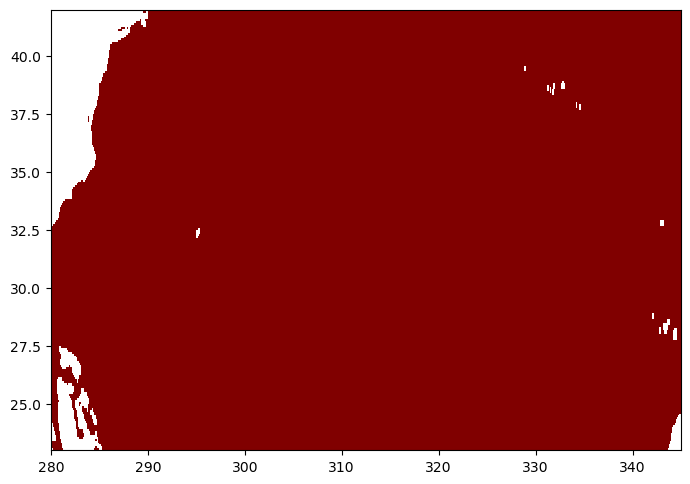

In [46]:
delta_isub = [21]
labels = [['a','b','c'],
          ['d','e','f'],
          ['g','h','i']]

fig, ax = plt.subplots(figsize=(9,5))
fig.tight_layout()
plt.subplots_adjust(left=0.1, right = 0.8)

dd = 0
for d_index in delta_isub:
    im0 = ax.pcolormesh(Pi_mean.isel(delta_outer = d_index).XG, 
                            Pi_mean.isel(delta_outer = d_index).YG, 
                            Pi_mean.isel(delta_outer = d_index), 
                            vmin=1.4e-10, vmax=2.2e-10, cmap='jet', 
                            rasterized=True
                           )   
    ax.contour(Pi_mean.isel(delta_outer = d_index).XG, 
                     Pi_mean.isel(delta_outer = d_index).YG, 
                     Pi_mean.isel(delta_outer = d_index),
                     levels = [1.5e-10,1.7e-10,1.9e-10],
                     linewidths=1.2, colors=['r','b','k'])

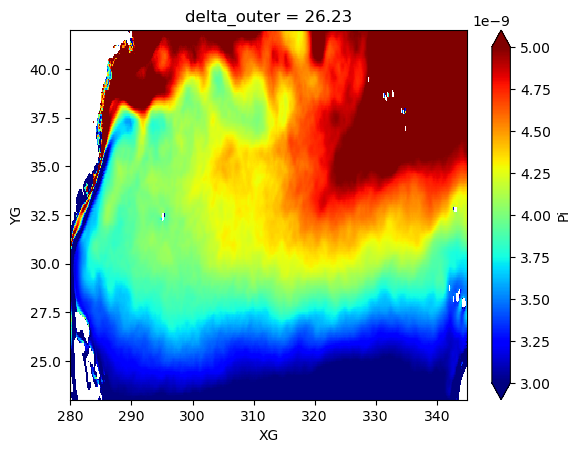

In [75]:
Pi_mean.isel(delta_outer = 28).plot(vmin = 3e-9,vmax = 5e-9,cmap = 'jet')

In [77]:
buoyb 

<xarray.DataArray 'delta' (delta: 54)>
array([-0.19933349, -0.20534379, -0.21045068, -0.21485509, -0.21870259,
       -0.22210127, -0.22513311, -0.22786145, -0.23033602, -0.23259645,
       -0.23467471, -0.23659691, -0.23838457, -0.24005564, -0.24162522,
       -0.2431061 , -0.24450921, -0.24584398, -0.24711859, -0.24834018,
       -0.24951504, -0.25064877, -0.25174633, -0.25281222, -0.2538505 ,
       -0.25486489, -0.25585879, -0.25683539, -0.25779766, -0.25874842,
       -0.25969035, -0.26062604, -0.26155801, -0.26248874, -0.26342072,
       -0.26435641, -0.26529833, -0.26624909, -0.26721136, -0.26818796,
       -0.26918187, -0.27019625, -0.27123453, -0.27230042, -0.27339798,
       -0.27453171, -0.27570657, -0.27692816, -0.27820277, -0.27953754,
       -0.28094066, -0.28242153, -0.28399111, -0.28566218])
Coordinates:
  * delta    (delta) float64 20.32 20.93 21.45 21.9 ... 28.63 28.78 28.94 29.11

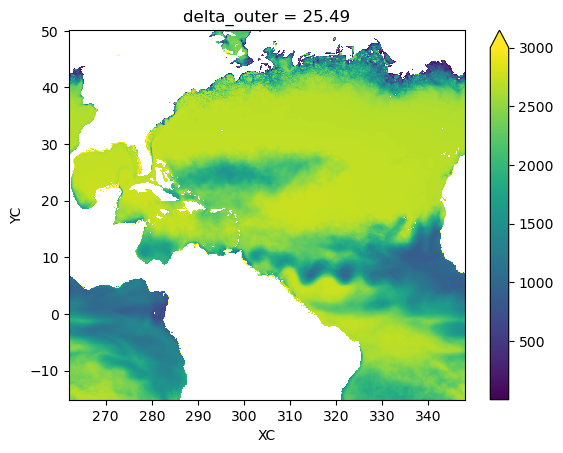

In [83]:
sigmab.isel(delta_outer = 21).plot(vmax = 3000)

# Flow dynamics

In [17]:
year = years[0]
XG_sub = [270, 350]#[280, 345]
YG_sub = [10, 50]#[23, 42]
d_index = 21
for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    ds_div = xr.open_zarr(op.join(savedir,twadir,'run%4d/divE-P/%010d/' 
                                            % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    ###
    Pi_tmp = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                         YG = slice(YG_sub[0],YG_sub[1])).isel(
                         delta_outer = d_index) * grav**-1
    
    buoyancy = - grav * Pi_tmp.delta_outer * rho0**-1

    u_tmp = dsb.uhat.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
    v_tmp = dsb.vhat.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
    varpi_tmp = dsb.varpihat.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
    
    Eu_tmp = (ds_div.e00x.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index)
        + ds_div.e10y.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
        + ds_div.e20_0b.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
        + ds_div.e20_1b.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
             )
    
    Ev_tmp = (ds_div.e01x.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
        + ds_div.e11y.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
        + ds_div.e21_0b.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
        + ds_div.e21_1b.sel(XC = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])).isel(
                     delta_outer = d_index) 
             )
    
            
    if itime == ntimes[0,0]:
        Pi = Pi_tmp
        u = u_tmp
        v = v_tmp
        varpi = varpi_tmp
        Eu = Eu_tmp
        Ev = Ev_tmp
        
    else:
        Pi = xr.concat([Pi, Pi_tmp],'ntime')
        u = xr.concat([u, u_tmp],'ntime')
        v = xr.concat([v, v_tmp],'ntime')
        varpi = xr.concat([varpi, varpi_tmp],'ntime')
        Eu = xr.concat([Eu, Eu_tmp],'ntime')
        Ev = xr.concat([Ev, Ev_tmp],'ntime')
        
Pi.coords['ntime'] = ('ntime',range(73))   
u.coords['ntime'] = ('ntime',range(73))   
v.coords['ntime'] = ('ntime',range(73))   
varpi.coords['ntime'] = ('ntime',range(73))   
Eu.coords['ntime'] = ('ntime',range(73))   
Ev.coords['ntime'] = ('ntime',range(73))   

# time-mean of each months
Pi_mean = Pi.mean('ntime',skipna=True) 
u_mean = u.mean('ntime',skipna=True) 
v_mean = v.mean('ntime',skipna=True) 
varpi_mean = varpi.mean('ntime',skipna=True) 
Eu_mean = Eu.mean('ntime',skipna=True) 
Ev_mean = Ev.mean('ntime',skipna=True) 


#     delta = .5*(dsz.delta_outer[1:].data 
#                 + dsz.delta_outer[:-1].data)
#     dsz.coords['delta'] = ('delta',delta)

#     grid = Grid(dsz, periodic=['X'], 
#                 coords={'Z':{'center':'delta','outer':'delta_outer'},
#                         'Y':{'center':'YC','left':'YG'},
#                         'X':{'center':'XC','left':'XG'}}
#            )

#     buoyb = -grav * dsz.delta * rho0**-1
#     buoybp1 = -grav * dsz.delta_outer * rho0**-1


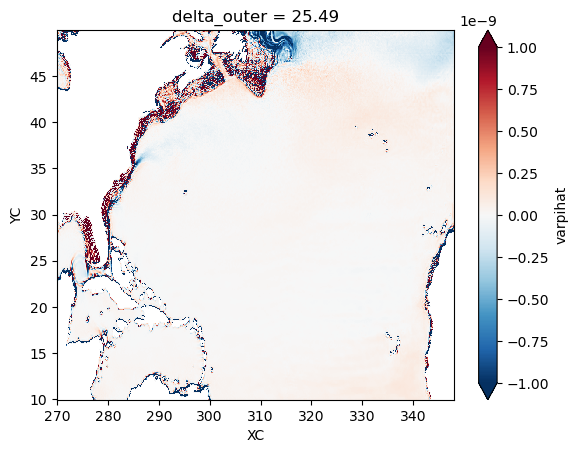

In [23]:
varpi_mean.plot(vmax = 1e-9)

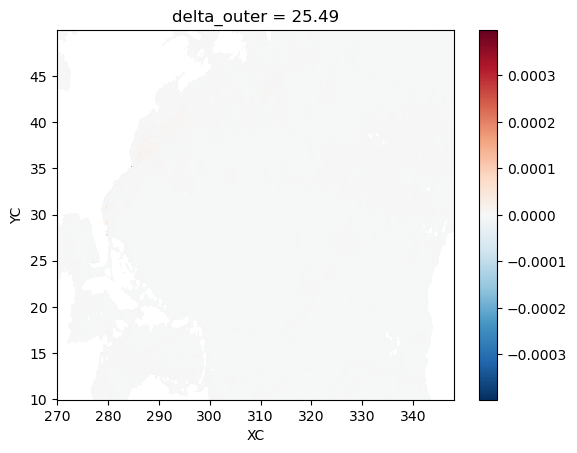

In [24]:
Eu_mean.plot()